# Gauss-Newton for Logistic Regression
In addition to the gradient of the log-likelihood, we now also consider the Hessian of the log-likelihood.

But first, we implement backtracking in our simple gradient descent approach to logistic regression.

In [1]:
include("../jl/UCBAdmit_Logit.jl")
include("../jl/admissionll.jl")
include("../jl/admissiongr.jl")

Variable `Y` has the observed variable.
Variable `X` has the explanatory variables.


admitgr (generic function with 1 method)

## Add Backtracking to Gradient Descent
As long as we start with a large enough intial step size, this improves things.  Here, I use an initial step size of 7 from previous work.

In [2]:
function backtrack(S,∇S₀,p,X₀,Y, X, counts; α₀ = 7.0, ρ = 0.5, c = 0.2)
  S₀ = S(X₀, Y, X, counts)
  relaxSlope = c*p'*(∇S₀'*S₀)
  condition(step) = 0.5*dot(S₀,S₀) + step*relaxSlope[1]

    α = deepcopy(α₀)
  Sₐ = S₀ #Ensures appropriate scope of Sₐ
  try
    Sₐ = S(X₀ + α*p, Y, X, counts)
  catch
  end
  while 0.5*dot(Sₐ,Sₐ) > condition(α)
    α = ρ*α
    try
      Sₐ = S(X₀ + α*p, Y, X, counts)
    catch
      continue
    end
  end

  return α
end

backtrack (generic function with 1 method)

In [3]:
function logitback(S,∇S, B; 
        Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-8, maxiter = 25)
  i = 1
  ll = Array{Float64}(undef, maxiter)
  stepsize = Array{Float64}(undef, maxiter)
  S₀ = S(B, Y, X, counts)
  ll[i] = S₀
  ∇S₀ = ∇S(B, Y, X, counts)
  while norm(∇S₀) > ϵ && i <= maxiter
    i += 1
    #Search Direction
    ∇S₀ = ∇S(B, Y, X, counts)
    p = ∇S₀'
    #Step Length
    α = backtrack(S,∇S₀,p,B,Y,X,counts)
    stepsize[i-1] = α
    #Update Parameter
    B += α*p
    #Update Likelihood
    S₀ = S(B, Y, X, counts)
    ll[i] = S₀
  end

  return B, i, ll, stepsize
end

logitback (generic function with 1 method)

In [4]:
B = [1 1 1 1 1 1 1]
sol, iters, ll, ss = logitback(admitll, admitgr, B; 
    Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-6, maxiter=3000);
sol'

7×1 Adjoint{Float64,Array{Float64,2}}:
  0.5820086873912498 
  0.09984509848147546
 -0.04334519823831905
 -1.262531637173279  
 -1.2945435134626389 
 -1.7392299740688475 
 -3.306360500719872  

In [5]:
iters
# ss[1:(iters-1)]

277

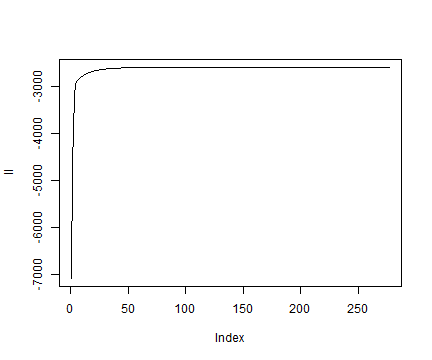

In [6]:
using RCall
ll = ll[1:iters]
@rput ll
reval("plot(ll, type='l')");

## Gauss-Newton
Add the Hessian.  A good step size seems to be 0.5 (1 goes singular).  Backtracking does not seem to be working for me.

In [7]:
function admithessian(B,Y,X,counts)
    Yf = convert(Array{Float64,1}, Y)
    H = zeros(24,24)
    for i in 1:24
        H[i,i] = (1/(1+exp(1).^(-dot(X[i,:],B))))*(1-(1/(1+exp(-dot(X[i,:],B))))).*counts[i]
    end
    return(X'*H*X./sum(counts))
end

admithessian (generic function with 1 method)

In [8]:
B = [1 1 1 1 1 1 1]'
admithessian(B,Y,X[:,1:7],X[:,8])

7×7 Array{Float64,2}:
 0.0988693   0.0197436   0.0132404   …  0.0134166   0.00835356  0.0120565 
 0.0197436   0.0197436   0.00024954     0.00374309  0.00392276  0.00340372
 0.0132404   0.00024954  0.0132404      0.0         0.0         0.0       
 0.0134584   0.00591908  0.0            0.0         0.0         0.0       
 0.0134166   0.00374309  0.0            0.0134166   0.0         0.0       
 0.00835356  0.00392276  0.0         …  0.0         0.00835356  0.0       
 0.0120565   0.00340372  0.0            0.0         0.0         0.0120565 

In [9]:
function logithess(S,∇S, B; 
        Y=Y, X=X[:,1:7], counts=X[:,8], alpha=1, ϵ=1e-8, maxiter = 25)
  i = 0
  S₀ = S(B, Y, X, counts)
  ∇S₀ = ∇S(B, Y, X, counts)
  while norm(∇S₀) > ϵ && i <= maxiter
    i += 1
    H = admithessian(B,Y,X,counts)
    #Search Direction
    ∇S₀ = ∇S(B, Y, X, counts)
    p = (inv(H)*∇S₀)
    #Step Length
    α = alpha #, evals = backtrack(S,∇S₀,p',B,Y,X,counts)
    #Update Parameter
    B += α*p
    #Update Gradient
    S₀ = S(B, Y, X, counts)
  end

  return B, i
end

logithess (generic function with 1 method)

In [10]:
sol, iter = logithess(admitll, admitgr, B; 
    Y=Y, X=X[:,1:7], counts=X[:,8], alpha=.5, ϵ=1e-8, maxiter=100);
sol

7×1 Array{Float64,2}:
  0.5820513935491944 
  0.09987010794011598
 -0.04339792880435035
 -1.2625980231213016 
 -1.294606467839948  
 -1.7393057294669734 
 -3.3064799799069564 

In [11]:
iter

28

In [14]:
function logitbackhess(S,∇S, B; 
        Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-8, maxiter = 25)
  i = 0
  S₀ = S(B, Y, X, counts)
  ∇S₀ = ∇S(B, Y, X, counts)
  while norm(∇S₀) > ϵ && i <= maxiter
    i += 1
    H = admithessian(B,Y,X,counts)
    #Search Direction
    ∇S₀ = ∇S(B, Y, X, counts)
    p = (inv(H)*∇S₀)
    #Step Length
    α = backtrack(S,∇S₀,p',B,Y,X,counts,α₀ = 0.5)
    #Update Parameter
    B += α*p
    #Update Gradient
    S₀ = S(B, Y, X, counts)
  end

  return B, i
end

logitbackhess (generic function with 1 method)

In [15]:
sol, iter = logitbackhess(admitll, admitgr, B; 
    Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-4, maxiter=1000);
sol

7×1 Array{Float64,2}:
 0.99999999832122  
 0.9999997758402204
 0.9999999344100008
 0.9999998471940122
 0.9999998456812654
 0.9999998021194471
 0.9999997406992922